# Post-process results

## Visualize Circuits

In [1]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()

In [2]:
#print circuit
print(qc)

        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
   c: 2/══════════════╬══╬═
                      ║  ║ 
meas: 2/══════════════╩══╩═
                      0  1 


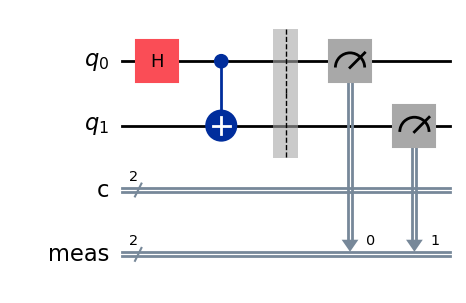

In [3]:
#using matplotlib
qc.draw("mpl")

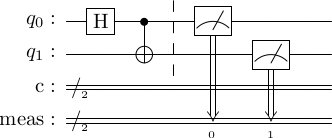

In [4]:
#In latex format
qc.draw("latex")

## Visualize Quantum States

In [5]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Statevector,DensityMatrix

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

psi = Statevector(qc)
dmatrix = DensityMatrix(psi)

In [6]:
#In LaTeX
display(psi.draw("latex"))
display(dmatrix.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

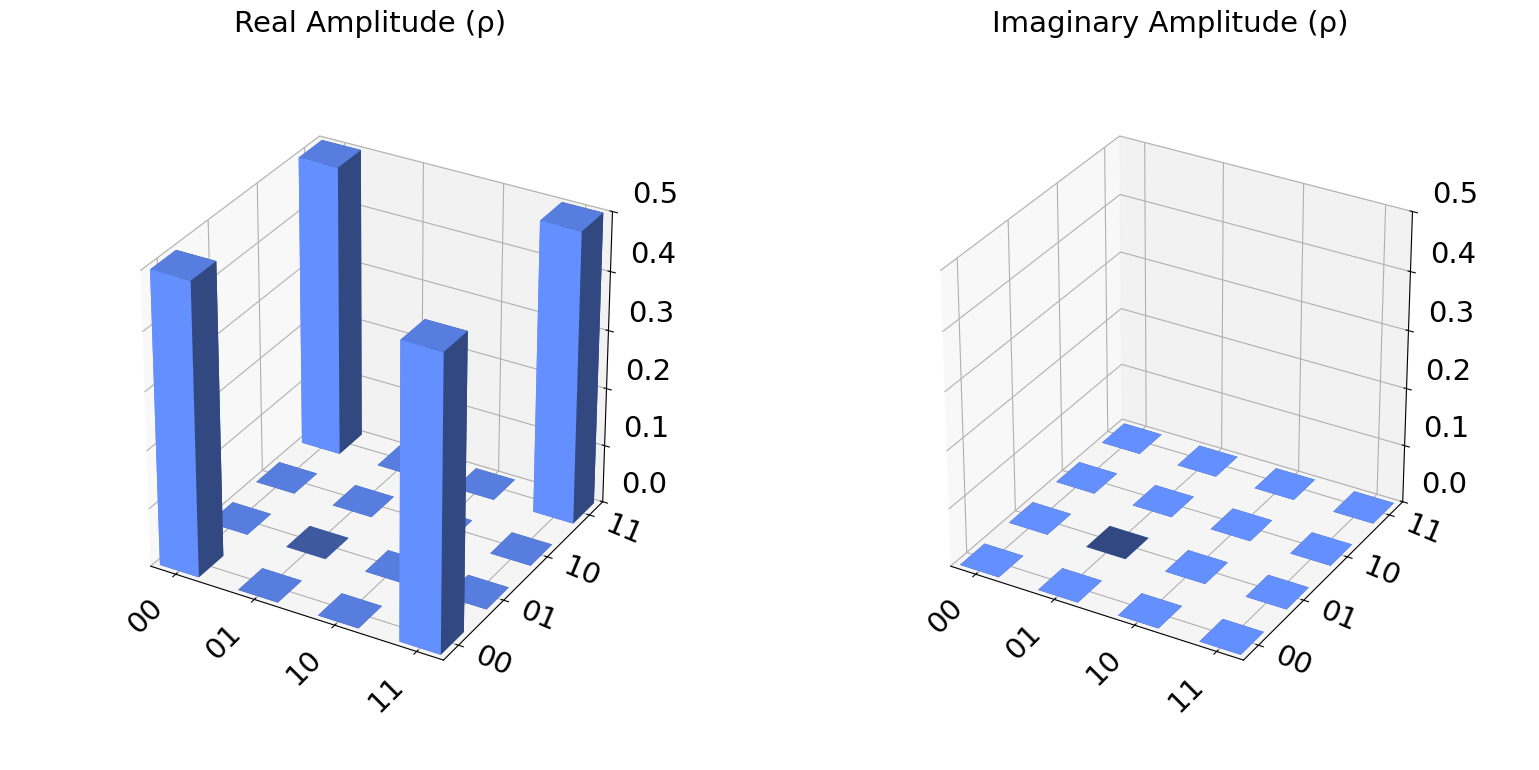

In [7]:
#Statecity plots
#Plots density matrix as real and imaginary parts seperately.
psi.draw("city")

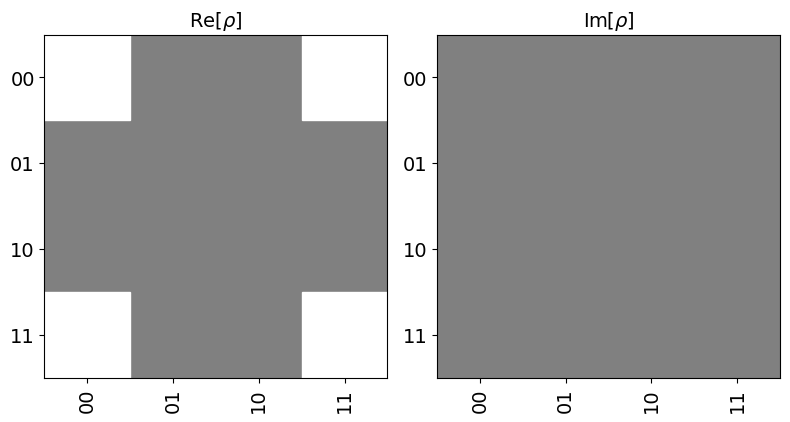

In [16]:
#Hinton plots
#same as city plots, instead of 3D plots, we have 2D plots
psi.draw("hinton")

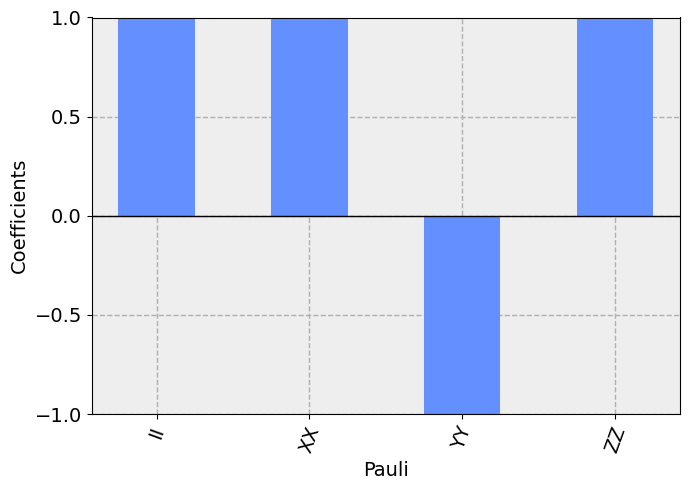

In [8]:
#Paulivector plot
# writing density matrix as linear combination of pauli strings
psi.draw("paulivec")

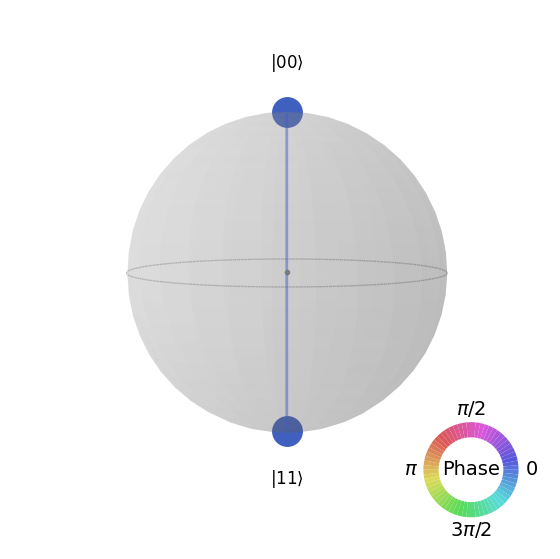

In [9]:
#QSphere
#The "QSphere" is a Qiskit-unique view of a quantum state in which the amplitude 
#and phase of each element in a statevector is plotted on the surface of a sphere.
psi.draw("qsphere")

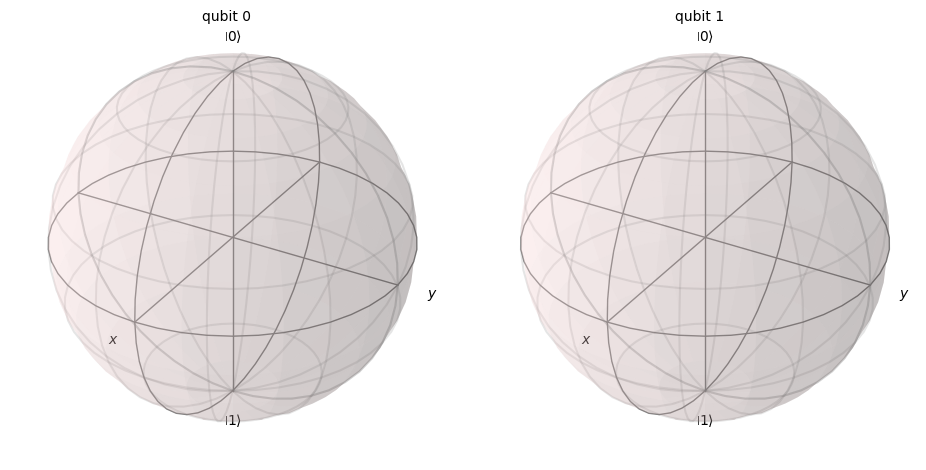

In [10]:
#The Bloch vector of a qubit state is its expectation value in the X, Y, and Z Pauli 
#observables mapped to the X, Y, and Z axes in three-dimensional space. 
psi.draw("bloch")

As bell state is maximally entangled at single qubit level, we don't see anything in bloch sphere plots.

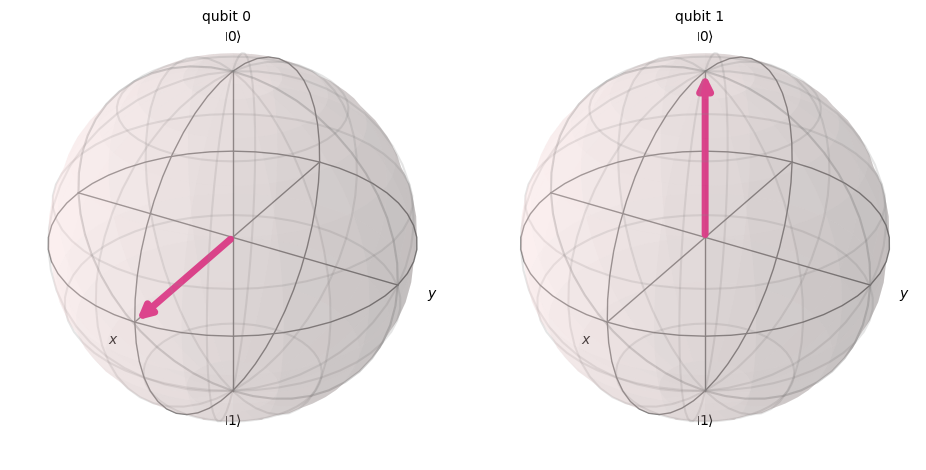

In [11]:
qc1 = QuantumCircuit(2)
qc1.h(0)
qc1.x(0)
s1 = Statevector(qc1)
s1.draw("bloch")

## Visualize Results

### Plotting Sampler Results

In [22]:
#Using "plot_histogram" function
from qiskit.circuit import QuantumCircuit
from qiskit import transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

fake_manila = FakeManilaV2()

# Bell Circuit 1/sqrt(2)(|00> + |11>)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
 
# transpilation
isa_qc = transpile(qc, backend = fake_manila, optimization_level =1)
 
# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
sampler = Sampler(mode=fake_manila, options=options)
 
result = sampler.run([isa_qc]).result()
data = result[0].data
counts = data.meas.get_counts()
print(f"Counts: {counts}")

Counts: {'11': 457, '00': 503, '01': 27, '10': 37}


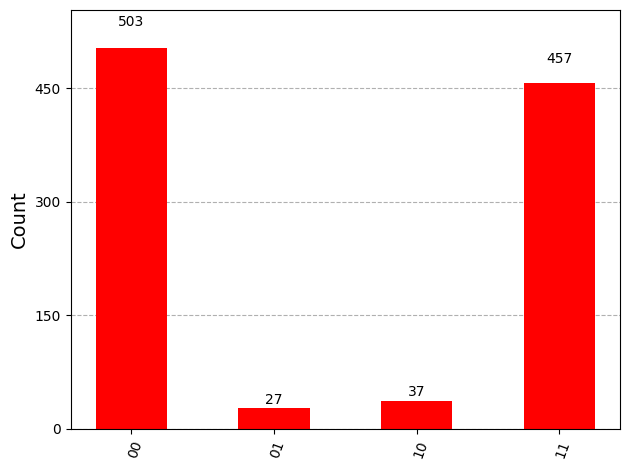

In [24]:
#Plotting histogram
from qiskit.visualization import plot_histogram
plot_histogram(counts,color = "red")

### Plotting Estimator results

Qiskit does not have a built-in function for plotting estimator results, but we can use "bar" plot of 'matplotlib'.

In [32]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.transpiler import generate_preset_pass_manager
from matplotlib import pyplot as plt

fake_manila = FakeManilaV2()
 
# Simple estimation experiment to create results
qc = QuantumCircuit(2)
qc.h(0)
qc.crx(1.5, 0, 1)

#Observables (seven)
observables_labels = ["ZZ", "XX", "YZ", "ZY", "XY", "XZ", "ZX"]
observables = [SparsePauliOp(label) for label in observables_labels]
 
#Transpilation 
pm = generate_preset_pass_manager(backend=fake_manila, optimization_level=1)
isa_circuit = pm.run(qc)
isa_observables = [
    operator.apply_layout(isa_circuit.layout) for operator in observables
]
 
# Reshape observable array
reshaped_ops = np.fromiter(isa_observables, dtype=object)
reshaped_ops = reshaped_ops.reshape((7, 1))
 
estimator = Estimator(mode = fake_manila)
job = estimator.run([(isa_circuit, reshaped_ops)])
result = job.result()[0]
exp_val = job.result()[0].data.evs
print(result)
print(f"Expectation values of observables: {exp_val.flatten()}")

PubResult(data=DataBin(evs=np.ndarray(<shape=(7, 1), dtype=float64>), stds=np.ndarray(<shape=(7, 1), dtype=float64>), shape=(7, 1)), metadata={'target_precision': 0.015625, 'shots': 4096, 'circuit_metadata': {}})
Expectation values of observables: [ 0.43164062 -0.00341797  0.40527344 -0.00341797 -0.57470703  0.02294922
  0.66357422]


<BarContainer object of 7 artists>

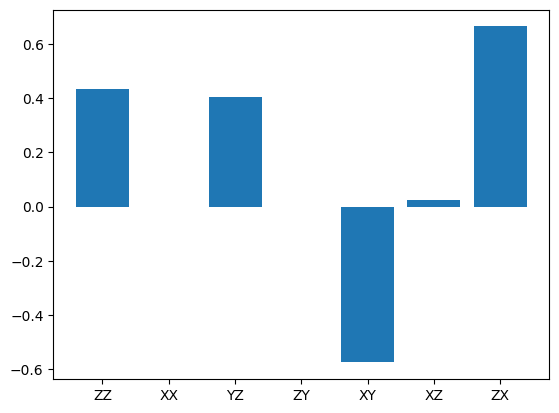

In [33]:
# Plot using Matplotlib
plt.bar(observables_labels, exp_val.flatten())

Text(0.5, 1.0, 'Expectation values (with standard errors)')

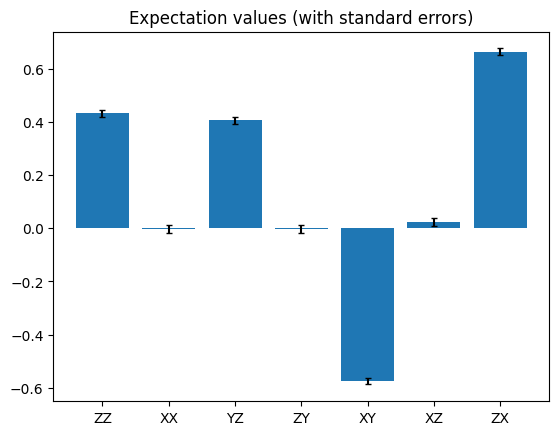

In [34]:
#Plotting including errors
std_err = job.result()[0].data.stds

_,ax = plt.subplots()
ax.bar(observables_labels, exp_val.flatten(),yerr = std_err.flatten(),capsize=2)
ax.set_title("Expectation values (with standard errors)")